# Informe nº6
    Notas: breve actualización del TFG. Modificación de los métodos teniendo en cuenta los comentarios de los tutores.
    Fecha: 18/07/2020
   
   ### Método de la integral de la luminancia de los píxeles
    Se define un método para la estimación de la radiación difusa aplicando la integral de la luminancia de los pixeles del cielo fuera del circumsolar.
    
   ### Definición de conjuntos de test     
    Se exponene algunos métodos para la creación de conjuntos de test, junto con la determinación de la calidad de estos conjuntos.

   ### Tuneado del factor gamma
    Se ha observado la correlación de las medidas del cielo cuando se produce una variaciín en el factor gamma aplicado a las imágenes.

In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install pvlib
!pip install pyephem
!pip install pandas
!pip install datetime
!pip install sklearn
!pip install seaborn

import cv2
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sn
import math
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pvlib as pv
from datetime import datetime as dt
from glob import glob

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from mascaras import *
from funciones_algoritmo import *
from muestra_imagenes import *

   ### Método de la integral de la luminancia de los píxeles
    Como se observó en el informe anterior con la corrección gamma, en teoria, se puede obtener la radaición percibida del cielo mediante la luminancia que se mide en un píxel. De esta forma, se propone un método en el cuál se realiza la medida de esta luminancia en todo el cielo, excepto en el disco solar, y se le aplica un método de regresión lineal.

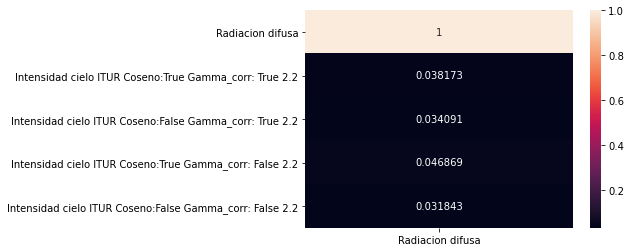

In [2]:
# Correlación entre las medidas y la radiación difusa para cielos nublados
pd_info_regresion_nublado = pd.read_csv('Datos/info_regresion_nublado_integral.csv')

# Matrices de correlación
Corr_matrix = pd_info_regresion_nublado.corr()
correlacion_difusa = Corr_matrix[['Radiacion difusa']].drop(['ghi', 'Zenith', 'Azimuth', 'Área solar', 'Radiacion', 'Factor solar', 'Ratio nubes', 'Intensidad cielo', 'Unnamed: 0', 'Intensidad nubes'])


sn.heatmap(correlacion_difusa, annot=True,  fmt='.5g')
plt.show()

In [3]:
# Correlación entre las medidas y la radiación difusa para cielos nublados
correlacion_difusa[['Radiacion difusa']]

,Radiacion difusa
Radiacion difusa,1.000000
Intensidad cielo ITUR Coseno:True Gamma_corr: True 2.2,0.038173
Intensidad cielo ITUR Coseno:False Gamma_corr: True 2.2,0.034091
Intensidad cielo ITUR Coseno:True Gamma_corr: False 2.2,0.046869
Intensidad cielo ITUR Coseno:False Gamma_corr: False 2.2,0.031843


In [4]:
lista_medidas_nublado = ['Intensidad cielo ITUR Coseno:True Gamma_corr: False 2.2']

y_rad_nublado = pd_info_regresion_nublado['Radiacion difusa']
x_rad_nublado = pd_info_regresion_nublado[lista_medidas_nublado]

# Se leen los datos utilziados para el test
pd_info_regresion_test_nublado = pd.read_csv('Datos/info_regresion_test_nublado_integral.csv')

x_rad_test_nublado = pd_info_regresion_test_nublado[lista_medidas_nublado]
y_rad_test_nublado = pd_info_regresion_test_nublado['Radiacion difusa']

In [5]:
# Modelo de regresión lineal normal
reg = LinearRegression()
reg.fit(x_rad_nublado, y_rad_nublado)

LinearRegression()

El coeficiente de determinación, R2, es 0.00.


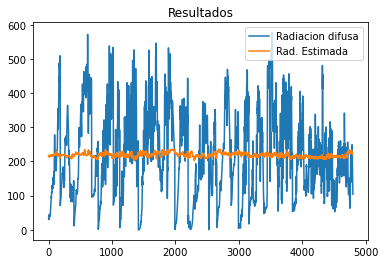

In [6]:
# Se observa el resulado de la estimación en el conjunto de datos global
predicted_rad = []
for i in range(len(x_rad_nublado)):
    predicted_rad.append(reg.predict([x_rad_nublado.iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion_nublado
pd_predicted['Rad. Estimada'] = predicted_rad

pd_predicted['Radiacion difusa'].plot(title='Resultados', legend=True)
pd_predicted['Rad. Estimada'].plot(legend=True)

score = reg.score(x_rad_nublado, y_rad_nublado)
print('El coeficiente de determinación, R2, es {:.2f}.'.format(score))

El coeficiente de determinación, para el conjunto de test,es -0.32.


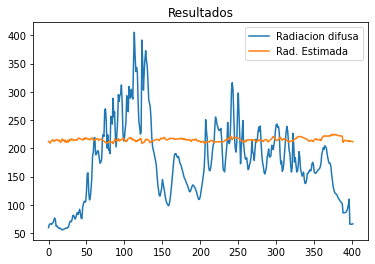

In [7]:
# Se realiza la predicción con los parámetros de test
predicted_rad = []
for i in range(len(pd_info_regresion_test_nublado)):
    predicted_rad.append(reg.predict([x_rad_test_nublado.iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion_test_nublado
pd_predicted['Rad. Estimada'] = predicted_rad

pd_predicted['Radiacion difusa'].plot(title='Resultados', legend=True)
pd_predicted['Rad. Estimada'].plot(legend=True)

score = reg.score(x_rad_test_nublado, y_rad_test_nublado)
print('El coeficiente de determinación, para el conjunto de test,es {:.2f}.'.format(score))

No hace falta obtener el error de las medidas, ya que se observa que los reuslatados obtenidos dejan mucho que desear. En teoría, con la corrección gamma se debería obtener una estimación de la radiación difusa acertada. En la práctica, se observa que los resultados no son adecuados.

   ### Definición de conjuntos de test
    Se proponen a continuación dos métodos para la creación de conjuntos de test a partir del conjunto de datos global.
   + Selección aleatoria de los datos: se selecciona, de forma aleatoria, un porcentaje del conjunto de datos global para ser el conjunto de test del modelo.
   + Selección por validación cruzada: este método consiste en repetir y calcular la media aritmética obtenida de las medidas de evaluación sobre diferentes particiones del conjunto global. Tiene como objetivo garantizar la independencia de la partición entre los datos de entrenamiento y prueba.

In [8]:
# Selección arbitraria del conjunto de test
pd_info_regresion_nublado = pd.read_csv('Datos/info_regresion_nublado_completo.csv')
lista_medidas_nublado = ['ghi', 'Factor solar', 'Ratio nubes', 'Intensidad cielo ITUR Coseno:False Gamma_corr:True']

y_rad_nublado = pd_info_regresion_nublado['Radiacion difusa']
x_rad_nublado = pd_info_regresion_nublado[lista_medidas_nublado]

x_entren_nublado, x_test_nublado, y_entren_nublado, y_test_nublado = train_test_split(x_rad_nublado, y_rad_nublado, test_size=0.3, random_state=42)
pd_info_regresion_test_nublado = pd_info_regresion_nublado.loc[x_test_nublado.index]

# Entrenamiento del modelo 
grados = 2
model = Pipeline([('poly', PolynomialFeatures(degree=grados)),
                  ('linear', LinearRegression())])
model = model.fit(x_entren_nublado, y_entren_nublado)

# Se realiza la predicción con los parámetros de test
predicted_rad = []
for i in range(len(x_test_nublado)):
    predicted_rad.append(model.predict([x_test_nublado.iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion_test_nublado
pd_predicted['Rad. Estimada'] = predicted_rad

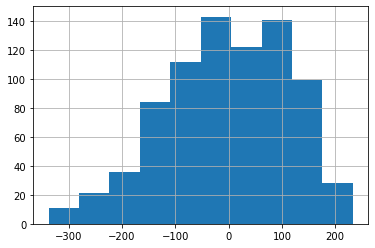

In [9]:
errores = pd_predicted['Rad. Estimada'] - pd_predicted['Radiacion difusa']
errores.hist()

In [10]:
RMSE = mean_squared_error(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'], squared=False)
expl_var = explained_variance_score(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'])

print('El RMSE es {:.2f}.'.format(RMSE))
print('La puntuación de varianza explicada es {:.2f}.'.format(expl_var))

El RMSE es 114.64.
La puntuación de varianza explicada es 0.23.


In [11]:
# Aplicación del método de la validación cruzada
# Definición para muestra de puntuación obtenida por la validación cruzada
def plot_bar_x(scrs):
    # this is for plotting purpose
    plt.bar(np.arange(len(scrs)), scrs)
    plt.xlabel('Iteración', fontsize=10)
    plt.ylabel('Puntuación', fontsize=10)
    plt.title('Puntuación validación cruzada')
    plt.show()

Precisión modelo lineal: -0.15 (+/- 1.15)


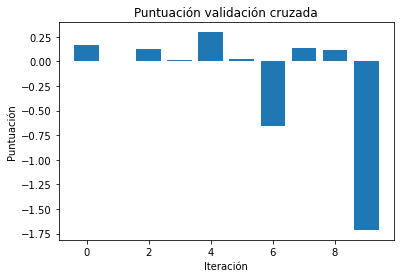

In [12]:
# Modelo lineal
reg = LinearRegression()
scores = cross_val_score(reg, x_rad_nublado, y_rad_nublado, cv=10)
print("Precisión modelo lineal: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

plot_bar_x(scores)

Precisión modelo cuadrático: -0.22 (+/- 1.14)


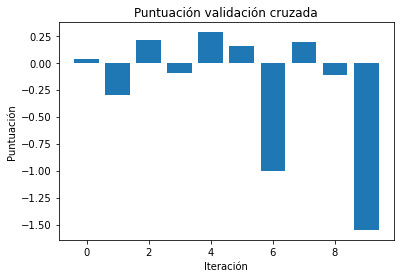

In [13]:
# Modelo cuadrático
model = Pipeline([('poly', PolynomialFeatures(degree=grados)),
                  ('linear', LinearRegression())])
scores = cross_val_score(model, x_rad_nublado, y_rad_nublado, cv=10)
print("Precisión modelo cuadrático: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

plot_bar_x(scores)

   ### Tuneado del factor gamma
    Como se vió en el informe anterior, la introducción del factor gamma aumenta la correlación de la intensidad de los píxeles medida con la radiación difusa percibida. Por este motivo se ha deciddo observar la variación de esta correlación cuando se modifica el valor gamma.

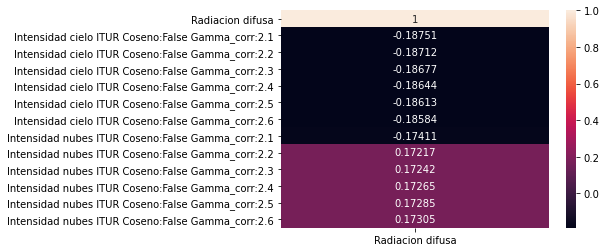

In [14]:
# Correlación entre las medidas y la radiación difusa para cielos nublados
pd_info_regresion_nublado = pd.read_csv('Datos/info_regresion_nublado_gamma.csv')

# Matrices de correlación
Corr_matrix = pd_info_regresion_nublado.corr()
correlacion_difusa = Corr_matrix[['Radiacion difusa']].drop(['ghi', 'Zenith', 'Azimuth', 'Área solar', 'Radiacion', 'Factor solar', 'Ratio nubes', 'Intensidad cielo', 'Unnamed: 0', 'Intensidad nubes'])


sn.heatmap(correlacion_difusa, annot=True,  fmt='.5g')
plt.show()

*Como vimos en el informe anterior, en cielos nublados, las correlación de la intensidad de las nubes es mucho mayor.

Según la bibliogafía, los valores más comunes de este factor se encuentran entre 2.2 y 2.5. En este caso observamos que la correlación aumenta ligeramente cuando aumenta el factor gamma, obteniendo el mejor resultado con un factor gamma de 2.6.

   ### Resultados y consulsiones

+ Concluimos que la obtención directa de la radiación percibida en un píxel mediante el cálculo de su luminancia/intensidad, y posterior corrección gamma, no ha sido la esperada según la base teórica. En la práctica podemos decir que el método acutal deja mucho que desear y no se puede utilziar para hacer una estimación de la radiación difusa.

+ Podemos decir que los resultados obtenidos por la selección del conjunto de test de forma aleatoria son satisfactorios. Pero este método presenta algunas deficiencias, como por ejemplo, al ser la selección del conjunto de test aleatoria, puede que los datos obtenidos no sean suficientemente respresentativos del conjunto de datos global, lo que puede conllevar a errores en la validación del método de predicción. Por otro lado, la validación cruzada debería reducir los efectos producidos por el efecto anteriormente comentado. Observamos que los resultados obtenidos por este método dejan mucho que desear, esto se puede deber a que el modelo que hemos obtenido no es los suficientemente adecuado, o por otro lado, los datos que se han utilizado presentan demasiada divergencia. En cualquier caso, para solventar estos problemas es necesario disponer de un conjunto de datos más amplio.

+ Sobre el factor gamma, podemos decir que los resultados obtenidos son similares en el rango que hemos observado, excepto en 2.1. Por este motivo se ha decidido que se va a mantener el valor de 2.2 utilizado hasta el momento, ya que no presenta grandes diferencias con los demás.

   ### Comentarios 
    Para la formación del conjunto de datos global, se han utilizdo imágenes correspondientes a los meses de mayo y junio.